# Classification with PyTorch/TensorFlow

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

## Part 1: Iris Classification

Iris Dataset contains 150 records of 3 different classes of irises. Each record contains 4 numeric parameters: sepal length/width and petal length/width. It is an example of a simple dataset, for which you do not need a powerful neural network.

### Getting the Dataset

Iris dataset is build into Scikit Learn, so we can easily get it:

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

iris = load_iris()
features = iris['data']
labels = iris['target']
class_names = iris['target_names']
feature_names = iris['feature_names']

print(f"Features: {feature_names}, Classes: {class_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], Classes: ['setosa' 'versicolor' 'virginica']


### Visualize the Data

In many cases, it makes sense to visualize the data to see if they look separable - it would assure us that we should be able to build good classification model. Because we have a few features, we can build a series of pairwise 2D scatter plots, showing different classes by different dot colors. This can be automatically done by a package called **seaborn**:

In [2]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(features,columns=feature_names).join(pd.DataFrame(labels,columns=['Label']))

df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


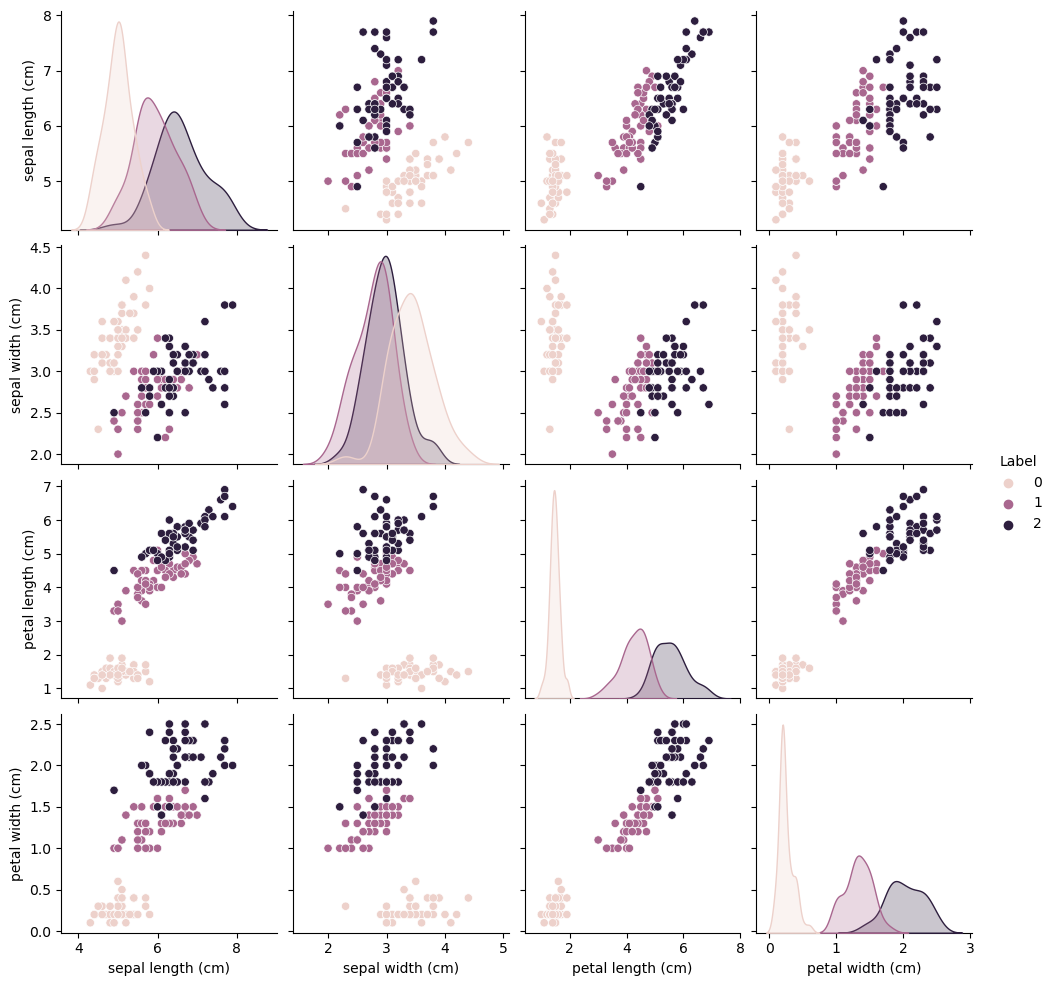

In [3]:
sns.pairplot(df,hue='Label')

### Normalize and Encode the Data

To prepare data to neural network training, we need to normalize inputs in the range [0..1]. This can be done either using plain `numpy` operations, or [Scikit Learn methods](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html).

Also, you need to decide if you want target label to be one-hot encoded or not. PyTorch and TensorFlow allow you feed in class number either as an integer (from 0 to N-1), or as one-hot encoded vector. When creating neural network structure, you need to specify loss function accordingly (eg. *sparse categorical crossentropy* for numeric representation, and *crossentropy loss* for one-hot encoding). One-hot encoding can also be [done using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), or by using this piece of code:

```python
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]
``` 

In [52]:
# Code to normalize and encode the data
import numpy as np

# Normalize the features and labels using numpy operations
features_min = np.min(features)
features_max = np.max(features)

features_norm = (features - features_min) / (features_max - features_min)

# One-hot encode the labels
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]

### Split the Data into Train and Test

Since we do not have separate train and test dataset, we need to split it intro train and test dataset [using Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [53]:
# Split the data
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test = train_test_split(features_norm, labels_onehot, test_size=0.2)

### Define and Train Neural Network

Now you are ready to go, import your preferred framework, define the neural network and start training, observing the behavior of train and validation accuracy.

In [54]:
# Import preferred framework
import tensorflow as tf
import matplotlib.pyplot as plt
import math

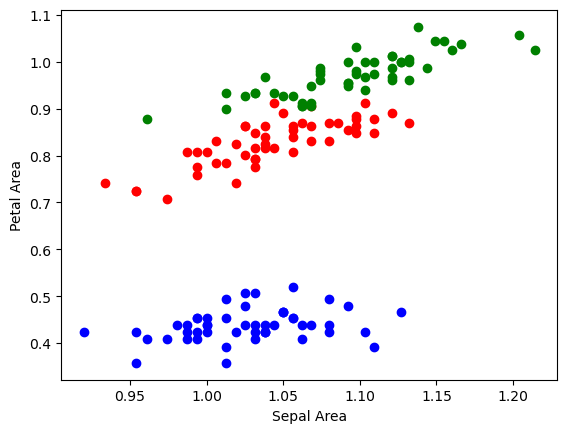

In [30]:
# Plot the dataset

# Return correct color for each label
def colors(label):
    if (label == 0):
        return 'bo'
    elif (label == 0.5):
        return 'ro'
    else:
        return 'go'

# Plots the original training dataset -- feature 1 vs feature 2
def plot_dataset(features, labels, x_title, y_title, W=None, b=None):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    for i in range(0, len(features)):
        c = colors(labels[i])
        plt.plot(features[i,0], features[i,1], c)

# Generate dataset with 2 features -- sepal area and petal area
f = np.empty((len(features_norm),2))
for i in range(0,len(features_norm)):
    f[i,0] = math.sqrt(features_norm[i,0] + features_norm[i,1])
    f[i,1] = math.sqrt(features_norm[i,2] + features_norm[i,3])

# Plot a graph of the normalized training data -- sepal area vs petal area
plot_dataset(f, labels_norm, 'Sepal Area', 'Petal Area')

In [55]:
# Define the network

# Define the neural network parameters
W = tf.Variable(tf.random.normal(shape=(4, 3)), dtype=tf.float32)  # 4 features and 3 classes
b = tf.Variable(tf.zeros(shape=(3,), dtype=tf.float32))  # 3 classes
learning_rate = 0.1

@tf.function
def train_on_batch(x, y):
    with tf.GradientTape() as tape:
        z = tf.matmul(x, W) + b
        # Use softmax activation and categorical cross-entropy loss for multi-class classification
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=z))
    dloss_dw, dloss_db = tape.gradient(loss, [W, b])
    W.assign_sub(learning_rate * dloss_dw)
    b.assign_sub(learning_rate * dloss_db)
    return loss

In [58]:
# Train the network

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features_train.astype(np.float32), labels_train.astype(np.float32)))
dataset = dataset.shuffle(128).batch(2)

# Lists to store training and validation accuracy
train_accuracy_history = []
test_accuracy_history = []

for epoch in range(20):
    for step, (x, y) in enumerate(dataset):
        loss = train_on_batch(x, y)
        
    # Calculate training accuracy at the end of each epoch
    predictions = tf.argmax(tf.nn.softmax(tf.matmul(features_train.astype(np.float32), W) + b), axis=1)
    training_accuracy = np.mean(np.argmax(labels_train, axis=1) == predictions)
    train_accuracy_history.append(training_accuracy)
    
    # Calculate validation accuracy at the end of each epoch
    test_predictions = tf.argmax(tf.nn.softmax(tf.matmul(features_test.astype(np.float32), W) + b), axis=1)
    testing_accuracy = np.mean(np.argmax(labels_test, axis=1) == test_predictions)
    test_accuracy_history.append(testing_accuracy)
        
    print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.4170
Epoch 1: last batch loss = 0.2212
Epoch 2: last batch loss = 0.5602
Epoch 3: last batch loss = 0.4324
Epoch 4: last batch loss = 0.3765
Epoch 5: last batch loss = 0.5029
Epoch 6: last batch loss = 0.6470
Epoch 7: last batch loss = 0.4908
Epoch 8: last batch loss = 0.6736
Epoch 9: last batch loss = 0.7024
Epoch 10: last batch loss = 0.4121
Epoch 11: last batch loss = 0.7177
Epoch 12: last batch loss = 0.3240
Epoch 13: last batch loss = 0.6242
Epoch 14: last batch loss = 0.3930
Epoch 15: last batch loss = 0.2876
Epoch 16: last batch loss = 0.3800
Epoch 17: last batch loss = 0.4149
Epoch 18: last batch loss = 0.3466
Epoch 19: last batch loss = 0.7379


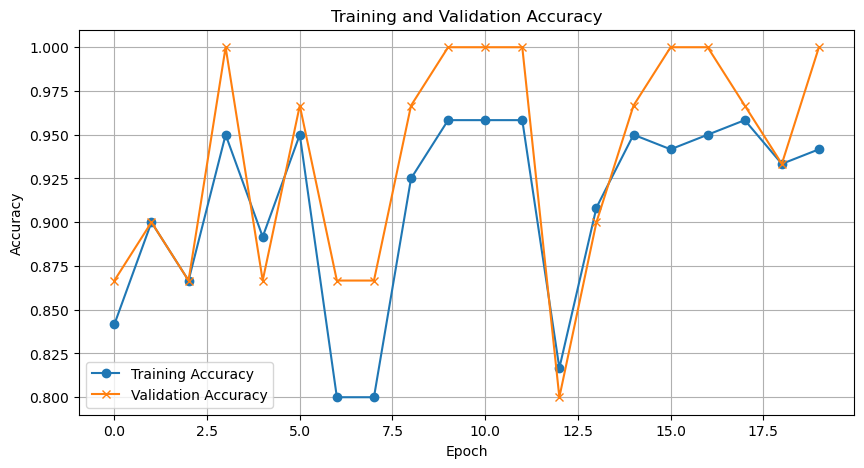

In [65]:
# Visualize train/validation accuracy graph
num_epochs = 20
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), train_accuracy_history, label='Training Accuracy', marker='o')
plt.plot(range(num_epochs), test_accuracy_history, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Experiment

Now you can experiment with different network architectures to see how it affects the result. Try:
1. One-layer network with 3 neurons (equal to the number of classes)
1. Two-layer network with small/medium/large hidden layer
1. Using more layers

Make sure you observe overfitting when you are using rich model with lots of neurons (parameters).

In [122]:
# Experiment

# Create a tf.data.Dataset object for easy batched iteration
dataset = tf.data.Dataset.from_tensor_slices((features_train.astype(np.float32), labels_train.astype(np.float32)))
dataset = dataset.shuffle(128).batch(2)

# Compile and train model
def run_model():
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print neural network summary
    model.summary()
    
    # Train model
    return model.fit(features_train, labels_train, validation_data=(features_test, labels_test), batch_size=8, epochs=20)

In [123]:
# 1. One-layer network with 3 neurons (equal to the number of classes)

# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(3, activation='softmax')  # One layer with 3 neurons
])

# Compile model, train model, and plot accuracy
one_layer_h = run_model()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_107 (Dense)           (None, 3)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 1.1809 - accuracy: 0.3167 - val_loss: 1.0616 - val_accuracy: 0.4000
Epoch 2/20
15/15 [==============================] - 0s 3ms/step - loss: 1.1018 - accuracy: 0.3167 - val_loss: 1.0327 - val_accuracy: 0.4000
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 1.0576 - accuracy: 0.3167 - val_loss: 1.0138 - val_accuracy: 0.4000
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 1.0302 - accuracy: 0.4667 - val_loss: 0.9990 - val_accuracy: 0.8000
Epoch 5/20
15/15 [======

In [124]:
# 2. Two-layer network with small/medium/large hidden layer

# Small hidden layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(8, activation='relu'),  # Small hidden layer
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model and call training loop
two_layer_small_h = run_model()

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_108 (Dense)           (None, 8)                 40        
                                                                 
 dense_109 (Dense)           (None, 3)                 27        
                                                                 
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 1s 13ms/step - loss: 1.0746 - accuracy: 0.3583 - val_loss: 1.0665 - val_accuracy: 0.3333
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0416 - accuracy: 0.4167 - val_loss: 1.0439 - val_accuracy: 0.3000
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 1.0058 - accuracy: 0.3917 - val_loss: 1.0118 - val_accuracy: 0.4000
Epoch 4/20
15/15 [==============

In [125]:
# Medium hidden layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(32, activation='relu'),  # Medium hidden layer
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model and call training loop
two_layer_med_h = run_model()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_110 (Dense)           (None, 32)                160       
                                                                 
 dense_111 (Dense)           (None, 3)                 99        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 1s 22ms/step - loss: 1.0337 - accuracy: 0.3667 - val_loss: 0.9679 - val_accuracy: 0.7000
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 0.9203 - accuracy: 0.6667 - val_loss: 0.8434 - val_accuracy: 0.6667
Epoch 3/20
15/15 [==============================] - 0s 8ms/step - loss: 0.7788 - accuracy: 0.6667 - val_loss: 0.7093 - val_accuracy: 0.6667
Epoch 4/20
15/15 [============

In [126]:
# Large hidden layer
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(4,)),
    tf.keras.layers.Dense(128, activation='relu'),  # Large hidden layer
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model and call training loop
two_layer_large_h = run_model()

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 128)               640       
                                                                 
 dense_113 (Dense)           (None, 3)                 387       
                                                                 
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 1s 14ms/step - loss: 0.9776 - accuracy: 0.5750 - val_loss: 0.8240 - val_accuracy: 0.8333
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 0.7308 - accuracy: 0.6833 - val_loss: 0.5933 - val_accuracy: 0.6667
Epoch 3/20
15/15 [==============================] - 0s 5ms/step - loss: 0.5001 - accuracy: 0.8667 - val_loss: 0.4762 - val_accuracy: 0.9667
Epoch 4/20
15/15 [========

Text(0, 0.5, 'Accuracy')

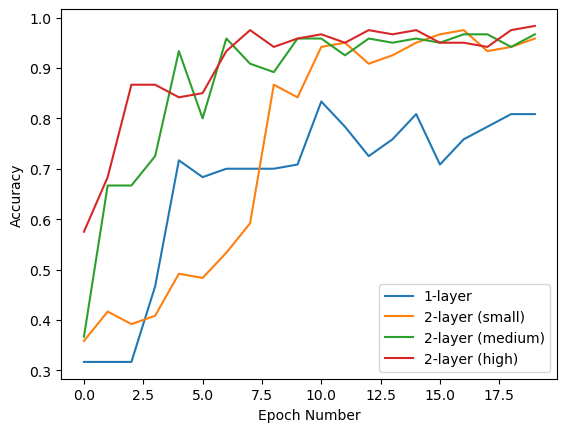

In [127]:
# Plot accuracy on same plot
plt.plot(one_layer_h.history['accuracy'])
plt.plot(two_layer_small_h.history['accuracy'])
plt.plot(two_layer_med_h.history['accuracy'])
plt.plot(two_layer_large_h.history['accuracy'])

plt.legend(["1-layer", "2-layer (small)", "2-layer (medium)", "2-layer (high)"], loc ="lower right")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

In [131]:
# 3. Using more layers

# Define neural network
def create_neural_network(dropout_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(4,)),
        tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 1
        tf.keras.layers.Dropout(dropout_rate),         # Add dropout
        tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 2
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(64, activation='relu'),  # Hidden layer 3
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

# Test different dropout rates
dropout_h = []
dps = [0.25, 0.35, 0.45, 0.55, 0.65, 0.75]
for dp in dps:
    create_neural_network(dp)
    h1 = run_model()
    dropout_h.append(h1)

Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 128)               640       
                                                                 
 dense_113 (Dense)           (None, 3)                 387       
                                                                 
Total params: 1,027
Trainable params: 1,027
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 [==============================] - 1s 15ms/step - loss: 0.0851 - accuracy: 0.9667 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 2/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0535 - accuracy: 0.9833 - val_loss: 0.0509 - val_accuracy: 0.9667
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0748 - accuracy: 0.9667 - val_loss: 0.0144 - val_accuracy: 1.0000
Epoch 4/20
15/15 [========

15/15 [==============================] - 0s 5ms/step - loss: 0.0598 - accuracy: 0.9667 - val_loss: 0.0110 - val_accuracy: 1.0000
Epoch 5/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0579 - accuracy: 0.9667 - val_loss: 0.0327 - val_accuracy: 0.9667
Epoch 6/20
15/15 [==============================] - 0s 4ms/step - loss: 0.0648 - accuracy: 0.9833 - val_loss: 0.0383 - val_accuracy: 0.9667
Epoch 7/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0642 - accuracy: 0.9750 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 8/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0477 - accuracy: 0.9750 - val_loss: 0.0464 - val_accuracy: 0.9667
Epoch 9/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0679 - accuracy: 0.9583 - val_loss: 0.0091 - val_accuracy: 1.0000
Epoch 10/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0615 - accuracy: 0.9667 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 11/20
15/15 [===========

15/15 [==============================] - 0s 4ms/step - loss: 0.0534 - accuracy: 0.9750 - val_loss: 0.0254 - val_accuracy: 0.9667
Epoch 13/20
15/15 [==============================] - 0s 6ms/step - loss: 0.0597 - accuracy: 0.9667 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 14/20
15/15 [==============================] - 0s 4ms/step - loss: 0.0873 - accuracy: 0.9667 - val_loss: 0.0369 - val_accuracy: 0.9667
Epoch 15/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0999 - accuracy: 0.9583 - val_loss: 0.0237 - val_accuracy: 1.0000
Epoch 16/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0728 - accuracy: 0.9750 - val_loss: 0.0106 - val_accuracy: 1.0000
Epoch 17/20
15/15 [==============================] - 0s 5ms/step - loss: 0.0649 - accuracy: 0.9667 - val_loss: 0.0206 - val_accuracy: 1.0000
Epoch 18/20
15/15 [==============================] - 0s 3ms/step - loss: 0.0596 - accuracy: 0.9750 - val_loss: 0.0123 - val_accuracy: 1.0000
Epoch 19/20
15/15 [======

Text(0, 0.5, 'Accuracy')

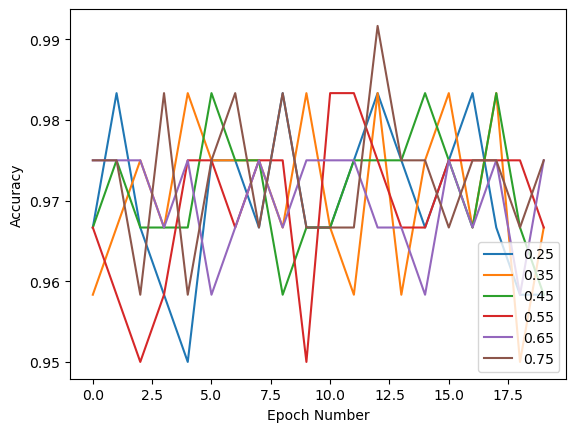

In [133]:
for d in dropout_h:
    plt.plot(d.history['accuracy'])

plt.legend(["0.25", "0.35", "0.45", "0.55", "0.65", "0.75"], loc ="lower right")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

## Part 2: MNIST Training

Both Keras and PyTorch contain MNIST as built-in dataset, so you can easily get it with a couple of lines of code ([Keras](https://keras.io/api/datasets/mnist/), [PyTorch](https://pytorch.org/vision/stable/datasets.html)). You will also be able to load both train and test datasets without manually splitting them.

In [148]:
# Load the dataset
MNIST = tf.keras.datasets.mnist.load_data(path="mnist.npz")

Now you need to perform the steps above to make sure dataset is normalized (it would probably already be), defining and training a neural network.

## Takeaway

1. Neural networks can be used for traditional machine learning tasks. However, they are in many cases too powerful, and can cause overfitting.
1. It is important in this assignment that you observe the overfitting behavior, and try to avoid it.
1. With frameworks like Keras, sometimes training a neural network is quite straightforward. But you need to understand what goes on.

In [152]:
# Create usable dataset from the MNIST data library

# Get data from MNIST
features = []
labels = []
for i in range(0,2):
    for feature in MNIST[i][0]:
        features.append(feature)
    for label in MNIST[i][1]:
        labels.append(label)
        
# Normalize the features and labels using numpy operations
features_min = np.min(features)
features_max = np.max(features)

features_norm = (features - features_min) / (features_max - features_min)

# One-hot encode the labels
n_values = np.max(labels) + 1
labels_onehot = np.eye(n_values)[labels]

# Seperate data/labels back into training/testing
features_train_len = len(MNIST[0][0])
labels_train_len = len(MNIST[0][1])

features_train = features_norm[0:features_train_len]
labels_train = labels_onehot[0:labels_train_len]

features_test = features_norm[features_train_len:]
labels_test = labels_onehot[labels_train_len:]

In [176]:
# Experiment

# Compile and train model
def run_model(model):
    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Print neural network summary
    model.summary()
    
    # Train model
    return model.fit(features_train, labels_train, validation_data=(features_test, labels_test), batch_size=64, epochs=5)

# Plot the specified model(s)
def plot_model(models, model_names):
    for model in models:
        plt.plot(model.history['accuracy'])
    
    plt.xlabel("Epoch Number")
    plt.ylabel("Accuracy")
    plt.legend(model_names, loc="lower right")

In [179]:
# Define the nerual networks

# Model 1: Convolutional Neural Network model
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Model 2: Deep neural network model (with dropout to address overfitting)
dropout_rate = 0.5
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Model 3: Simple neural network model
model_3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10)
])

In [180]:
# Run specified models
model_1_acc = run_model(model_1)
model_2_acc = run_model(model_2)
model_3_acc = run_model(model_3)

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 5, 5, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_13 (Flatten)        (None, 576)             

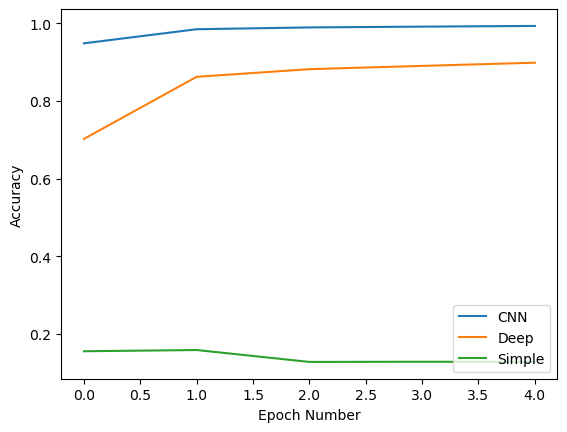

In [181]:
# Plot accuracy of each model against one another
models = [model_1_acc, model_2_acc, model_3_acc]
model_names = ["CNN", "Deep", "Simple"]
plot_model(models, model_names)